In [2]:
# Kaggle 预测房价
''' 
在整本书中，我们将下载不同的数据集，并训练和测试模型。这⾥我们实现⼏个函数来⽅便下载数据。⾸先，
我们建⽴字典DATA_HUB，它可以将数据集名称的字符串映射到数据集相关的⼆元组上，这个⼆元组包含数
据集的url和验证⽂件完整性的sha-1密钥。所有类似的数据集都托管在地址为DATA_URL的站点上。
'''
import hashlib
import os
import tarfile
import zipfile
import requests
#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [3]:
''' 
下⾯的download函数⽤来下载数据集，将数据集缓存在本地⽬录（默认情况下为../data）中，并返回下
载⽂件的名称。如果缓存⽬录中已经存在此数据集⽂件，并且其sha-1与存储在DATA_HUB中的相匹配，我们
将使⽤缓存的⽂件，以避免重复的下载。
'''
def download(name, cache_dir=os.path.join('..', 'data')): #@save
    """下载⼀个DATA_HUB中的⽂件，返回本地⽂件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
            if sha1.hexdigest() == sha1_hash:
                return fname # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [4]:
''' 
我们还需实现两个实⽤函数：⼀个将下载并解压缩⼀个zip或tar⽂件，另⼀个是将本书中使⽤的所有数据集
从DATA_HUB下载到缓存⽬录中。
'''
def download_extract(name, folder=None): #@save
    """下载并解压zip/tar⽂件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar⽂件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir
def download_all(): #@save
    """下载DATA_HUB中的所有⽂件"""
    for name in DATA_HUB:
        download(name)

In [5]:
# 访问和读取数据集 
''' 
注意，竞赛数据分为训练集和测试集。每条记录都包括房屋的属性值和属性，如街道类型、施⼯年份、屋顶
类型、地下室状况等。这些特征由各种数据类型组成。例如，建筑年份由整数表⽰，屋顶类型由离散类别表
⽰，其他特征由浮点数表⽰。这就是现实让事情变得复杂的地⽅：例如，⼀些数据完全丢失了，缺失值被简
单地标记为“NA”。每套房⼦的价格只出现在训练集中（毕竟这是⼀场⽐赛）。我们将希望划分训练集以创建
验证集，但是在将预测结果上传到Kaggle之后，我们只能在官⽅测试集中评估我们的模型。
'''
# 如果你没有安装pandas，请取消下⼀⾏的注释
# !pip install pandas

%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [6]:
# 使⽤上⾯定义的脚本下载并缓存Kaggle房屋数据集
DATA_HUB['kaggle_house_train'] = ( #@save
                                  DATA_URL + 'kaggle_house_pred_train.csv',
                                  '585e9cc93e70b39160e7921475f9bcd7d31219ce')
DATA_HUB['kaggle_house_test'] = ( #@save
                                 DATA_URL + 'kaggle_house_pred_test.csv',
                                 'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [7]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_train.csv下载../data/kaggle_house_pred_train.csv...
正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_test.csv下载../data/kaggle_house_pred_test.csv...


In [8]:
# 训练数据集包括1460个样本，每个样本80个特征和1个标签，
# ⽽测试数据集包含1459个样本，每个样本80个特征
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [9]:
# 查看前四个和最后两个特征，以及相应标签（房价）
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]) 
#iloc 可以查看csv文件具体内容
# .iloc[]纯整数基于位置的索引,主要基于整数位置,可与布尔数组一起使用

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [10]:
''' 
我们可以看到，在每个样本中，第⼀个特征是ID，这有助于模型识别每个训练样本。虽然这很⽅便，但它不
携带任何⽤于预测的信息。因此，在将数据提供给模型之前，我们将其从数据集中删除
'''
# 使用pandas读入并处理数据
# pd.concat() 可沿指定轴将多个dataframe(数据帧)或者series拼接到一起,默认拼接方式为上下堆叠(axis=0)
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:])) # 训练集与测试集拼接
# train_data.iloc[:, 1:-1] iloc遵循左闭右开原则 训练集不包含最后一项,即不包含销售价格
# id一般是提交结果用的,不能参与训练
# 如果拟合id,就成了记住了整个样本,因为每个样本都有一个id

In [11]:
# 数据预处理
''' 
在开始建模之前，我们需要对数据进⾏预处理。⾸先，我们将所有缺失的值替换为相应特征的平均值。
然后，为了将所有特征放在⼀个共同的尺度上，我们通过将特征重新缩放到零均值和单位⽅差来标准化数据
x ← (x − µ)/σ
其中µ和σ分别表⽰均值和标准差。现在，这些特征具有零均值和单位⽅差
直观地说，我们标准化数据有两个原因：⾸先，它⽅便优化。
其次，因为我们不知道哪些特征是相关的，所以我们不想让惩罚分配给⼀个特征的系数⽐分配给其他任何特征的系数更⼤
'''
#将所有缺失的值替换为相应特征的平均值。 通过将特征重新缩放到零均值和单位方差来标准化数据
 
# 若⽆法获得测试数据，则可根据训练数据计算均值和标准差
# 将非字符串的特征取出来放在numeric_features
# 返回每个列的布尔值,类型不满足object为ture,否则为false object str类型 用于文本
# 即提取所有数字特征
# object是str类或数字混合类型（mixed），将特征为数字的列单独拿出。并保存列名到numeric
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index  # 排除object类的特征
# print(numeric_features)
# 标准化数据 将特征的均值变为0,方差变为1
all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))
# 此处将训练集与测试集放在一起算方差(做比赛,已经有测试集,算是小小的作弊),
# 但实际情况不一定能这么做,可能在训练集上算均值,将其用在测试集上
# 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0,即将缺失值填充为0
all_features[numeric_features] = all_features[numeric_features].fillna(0) 
# fillna 将没有采样到的变为0(因为均值为0)

In [12]:
''' 
接下来，我们处理离散值。这包括诸如“MSZoning”之类的特征。我们⽤独热编码替换它们，⽅法与前⾯
将多类别标签转换为向量的⽅式相同（请参⻅ 3.4.1节）。例如，“MSZoning”包含值“RL”和“Rm”。我
们将创建两个新的指⽰器特征“MSZoning_RL”和“MSZoning_RM”，其值为0或1。根据独热编码，如果
“MSZoning”的原始值为“RL”，则：“MSZoning_RL”为1，“MSZoning_RM”为0。pandas软件包会⾃动
为我们实现这⼀点
'''
# “Dummy_na=True将"na"（缺失值）视为有效的特征值，并为其创建指⽰符特征 
# get_dummies 即上述将离散值转换为指示特征 返回一个独热编码 dummies 假的;虚拟的
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [13]:
''' 
此转换会将特征的总数量从79个增加到331个。最后，通过values属性，我们可以从pandas格
式中提取NumPy格式，并将其转换为张量表⽰⽤于训练

values 属性返回 DataFrame 中的所有值。
返回值是一个二维数组，每行一个数组
'''
n_train = train_data.shape[0] # 训练集行数,即训练数目   
# values 返回 [:n_train] 的numpy结构,默认float64,所以这里变成32
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32) # 训练特征
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)  # 测试特征
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32) 
# 训练标签 价格 一列 将shape=(1460)转换为shape=(1460,1)

In [14]:
# 训练 
''' 
⾸先，我们训练⼀个带有损失平⽅的线性模型。显然线性模型很难让我们在竞赛中获胜，但线性模型提供了
⼀种健全性检查，以查看数据中是否存在有意义的信息。如果我们在这⾥不能做得⽐随机猜测更好，那么我
们很可能存在数据处理错误。如果⼀切顺利，线性模型将作为基线（baseline）模型，让我们直观地知道最
好的模型有超出简单的模型多少。
'''
# 训练一个线性模型作为基线模型
loss = nn.MSELoss() # 平方损失 又称为均方损失 R^2 SSE
in_features = train_features.shape[1] # 输入特征
def get_net(): # 实例化nn
    net = nn.Sequential(nn.Linear(in_features,1)) # 单层线性回归
    return net

In [15]:
# 我们更关心"相对误差(绝对误差会使高价房的误差权重增大)" -> (𝑦−𝑦̂)/𝑦 --
# -->> 取log(因为有除法在里面)(比较大的值,正的值做回归时通常用log)
# 解决这个问题的一种方法是用价格预测的对数来衡量差异
# 这也是⽐赛中官⽅⽤来评价提交质量的误差指标
def log_rmse(net, features, labels): # rmse 均方根误差（root-mean-square error）对数均方根误差
    # 为了在取对数时进⼀步稳定该值，将⼩于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf')) # float('inf')代表的是正无穷 clamp 夹紧,固定住
    # torch.clamp(input, min, max, out=None) 将输入张量每个元素的范围限制到区间 [min,max]，返回结果到一个新张量
    # net的输出如果是inf,则将其变为1,log infinite(无穷大) 会出问题
    rmse = torch.sqrt(loss(torch.log(clipped_preds),torch.log(labels))) 
    # sqrt 平方根 loss 均方损失 -> 对数均方根误差
    return rmse.item() # 取出单元素张量的元素值并返回该值,保持原元素类型不变
# 即将单元素的张量转为对应的int型或者float型
# item()返回的是一个浮点型数据，所以我们在求loss或者accuracy时，一般使用item()，而不是直接取它对应的元素x[1,1]

In [16]:
''' 
与前⾯的部分不同，我们的训练函数将借助Adam优化器（我们将在后⾯章节更详细地描述它）。Adam优化
器的主要吸引⼒在于它对初始学习率不那么敏感
'''
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], [] # 训练/测试损失
    train_iter = d2l.load_array((train_features, train_labels), batch_size) # 训练迭代器
    # 这⾥使⽤的是Adam优化算法,之前都是sgd,Adam好处为对学习率没那么敏感,lr 的适用范围会宽一点
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs): # 迭代
        for X, y in train_iter:   # 取出小批次的特征和标签
            optimizer.zero_grad() # 梯度清零
            l = loss(net(X), y)   # 损失
            l.backward()          # 自动微分 反向传播计算得到每个参数的梯度值
            optimizer.step()      # 更新参数 通过梯度下降执行一步参数更新
        train_ls.append(log_rmse(net, train_features, train_labels))  # 训练损失 对数均方根损失
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels)) # 测试损失 对数均方根损失
    return train_ls, test_ls # 返回训练/测试损失


In [17]:
# K折交叉验证
# 获取k折交叉验证数据
''' 
你可能还记得，我们在讨论模型选择的部分（4.4节）中介绍了K折交叉验证，它有助于模型选择和超参数调
整。我们⾸先需要定义⼀个函数，在K折交叉验证过程中返回第i折的数据。具体地说，它选择第i个切⽚作为
验证数据，其余部分作为训练数据。注意，这并不是处理数据的最有效⽅法，如果我们的数据集⼤得多，会
有其他解决办法。
'''
# 将训练集与测试集分开,如取出第二份做测试集则其他四份做训练集
def get_k_fold_data(k, i, X, y): # k-折数；i-验证集为第i折；X-特征；y-标签
    assert k > 1 # 确保大于一折
    # 返回第i折交叉验证时所需要的训练和验证数据，分开放，X_train为训练数据，X_valid为验证数据
    fold_size = X.shape[0] // k # 每折大小,即每份的个数: 数据总条数/折数（组数） //  除完之后向下取整
    # 因为计算fold_size是使用的是向下取整，所以余数会被舍弃,即代码中有些样本会被舍弃
    X_train, y_train = None, None # 初始化
    for j in range(k):
        # 在1到k折进行循环
        idx = slice(j * fold_size, (j + 1) * fold_size) # 切片 获取第j折的索引 即第j个集合切片对象的集合
        # slice(start, stop[, step])；start:开始位置，stop:结束位置，step：间距
        # 训练集被分成k折,每折大小为fold_size
        X_part, y_part = X[idx, :], y[idx] # 第j折对应的 X y 
        # 如果当前的集合是第i折交叉验证，就将当前的集合当作验证模型
        if j == i: # j=i就是当前所取部分刚好是要当验证集的部分
            X_valid, y_valid = X_part, y_part # 将当前所取集合放进验证集
        elif X_train is None: # 如果j!=i且X_train是空的则直接将此部分放进训练集,即第一次看到将其存起来
            X_train, y_train = X_part, y_part        # 不然就是将当前的X_part和之前的X_train连接起来
        else: # 如果j!=i且访问到其余除了验证集（j=i）其余集合的子集，就使用concat连接已经放进训练集的集合
            X_train = torch.cat([X_train, X_part], 0) # cat concatenate 拼接,将两个Tensor拼接在一起
            y_train = torch.cat([y_train, y_part], 0) # 按维数0（行）拼接——A、B的列数必须相同
    return X_train, y_train, X_valid, y_valid # 返回第i折对应的训练集和测试集 
    # X_train 训练集特征 y_train 训练集标签 X_valid 验证集特征 y_valid 验证集标签

In [18]:
# k折交叉验证
# 当我们在K折交叉验证中训练K次后，返回训练和验证误差的平均值
''' 
python函数星号参数详解
函数在定义中，通过在参数前加星号，将传递进来的多个参数转化为一个对象，元组或字典，可以说是将这些参数值收集起来
参数前加一个星号，表明将所有的值放在同一个元组中，该参数的返回值是一个元组
参数前加两个星号，表明将所有的值放在同一个字典中，该参数的返回值是一个字典
'''
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,batch_size):
    train_l_sum, valid_l_sum = 0, 0 # 初始化训练/验证损失和
    for i in range(k): # i表示第i折交叉验证  做k次
        data = get_k_fold_data(k, i, X_train, y_train) # 获取k折交叉验证的训练和验证数据
        net = get_net() # 获得net实例  此处为基本的线性回归模型
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size) # 计算训练/验证损失
        '*data可以分别读取数据，在这里等于是得到了get_k_fold_data函数的return的四个表，直接写data会导致缺位置参数'
        train_l_sum += train_ls[-1] # 训练损失和 
        valid_l_sum += valid_ls[-1] # 测试损失和
        if i == 0: 
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                    xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                    legend=['train', 'valid'], yscale='log') # 画图，且是对y求对数了，x未变
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, 'f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k # 返回平均训练/验证损失

折1，训练log rmse0.129842, 验证log rmse0.151632
折2，训练log rmse0.130835, 验证log rmse0.117905
折3，训练log rmse0.132278, 验证log rmse0.131666
折4，训练log rmse0.126915, 验证log rmse0.158710
折5，训练log rmse0.125674, 验证log rmse0.162334
折6，训练log rmse0.131125, 验证log rmse0.118503
折7，训练log rmse0.130924, 验证log rmse0.130480
折8，训练log rmse0.130691, 验证log rmse0.140195
折9，训练log rmse0.124091, 验证log rmse0.186263
折10，训练log rmse0.129932, 验证log rmse0.140867
10-折验证: 平均训练log rmse: 0.129231, 平均验证log rmse: 0.143856


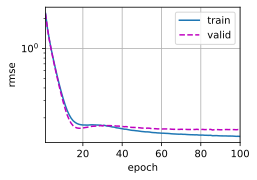

In [43]:
# 模型选择
''' 
在本例中，我们选择了⼀组未调优的超参数，并将其留给读者来改进模型。找到⼀组调优的超参数可能需要
时间，这取决于⼀个⼈优化了多少变量。有了⾜够⼤的数据集和合理设置的超参数，K折交叉验证往往对多
次测试具有相当的稳定性。然⽽，如果我们尝试了不合理的超参数，我们可能会发现验证效果不再代表真正
的误差
'''
k, num_epochs, lr, weight_decay, batch_size = 10, 100, 20, 0, 64 # 未调优的超参数
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size) # k折交叉验证
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}') # 打印训练/验证损失

In [44]:
# 提交Kaggle预测
''' 
请注意，有时⼀组超参数的训练误差可能⾮常低，但K折交叉验证的误差要⾼得多，这表明模型过拟合了。在
整个训练过程中，你将希望监控训练误差和验证误差这两个数字。较少的过拟合可能表明现有数据可以⽀撑
⼀个更强⼤的模型，较⼤的过拟合可能意味着我们可以通过正则化技术来获益
--------------------------------------------------------------------------------------------
使用k折交叉验证选择超参数与网络模型

既然我们知道应该选择什么样的超参数，我们不妨使⽤所有数据对其进⾏训练(本次数据集较小,可在完整的训练集上再训练一次)
（⽽不是仅使⽤交叉验证中使⽤的1 − 1/K的数据）。然后，我们通过这种⽅式获得的模型可以应⽤于测试集。
将预测保存在CSV⽂件中可以简化将结果上传到Kaggle的过程
'''
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size): # 训练和预测 weight_decay 权重衰减 加入L2正则
    net = get_net() # 获得net实例
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size) # 返回训练/测试损失
     # 单下划线 _ 单个独立下划线是用作一个名字，来表示某个变量是临时的或无关紧要的
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log') # 画图
    print(f'训练log rmse:{float(train_ls[-1]):f}') 
    # 将⽹络应⽤于测试集,在测试之前使用完整数据集重新训练模型,转换预测结果存成提交所需要的格式
    # 计算预测标签
    preds = net(test_features).detach().numpy() # detach 返回一个不具有grad的新tensor,从当前图形分离
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0]) # SalePrice标签列 
    # Series 带有轴标签（包括时间串行）的一维凹槽
    
    # 将测试集的Id和预测结果拼接在一起，axis沿水平方向拼接，与上面默认纵向拼接不同
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1) # concat 拼接
    submission.to_csv('submission.csv', index=False) # 转成可提交的csv格式


训练log rmse:0.128360


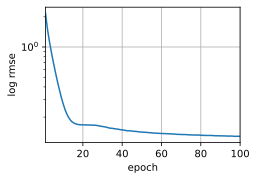

In [45]:
'''
设计好模型并调好超参数之后，接下来就是对测试数据集上的房屋样本做价格预测。
如果我们得到与交叉验证时差不多的训练误差，那么这个结果很可能是理想的，可以在Kaggle上提交结果
'''
# 该代码执行完之后会生成一个符合Kaggle比赛要求的提交格式的文件(submission.csv文件)
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)

In [ ]:
''' 
⼩结
• 真实数据通常混合了不同的数据类型，需要进⾏预处理。
• 常⽤的预处理⽅法：将实值数据重新缩放为零均值和单位⽅法；⽤均值替换缺失值。
• 将类别特征转化为指标特征，可以使我们把这个特征当作⼀个独热向量来对待。
• 我们可以使⽤K折交叉验证来选择模型并调整超参数。
• 对数对于相对误差很有⽤。
'''